In [10]:
!pip install seaborn

Dataset loaded successfully!
   film_code  cinema_code  total_sales  tickets_sold  tickets_out  show_time  \
0       1492          304      3900000            26            0          4   
1       1492          352      3360000            42            0          5   
2       1492          489      2560000            32            0          4   
3       1492          429      1200000            12            0          1   
4       1492          524      1200000            15            0          3   

   occu_perc  ticket_price  ticket_use    capacity        date  month  \
0       4.26      150000.0          26  610.328638  2018-05-05      5   
1       8.08       80000.0          42  519.801980  2018-05-05      5   
2      20.00       80000.0          32  160.000000  2018-05-05      5   
3      11.01      100000.0          12  108.991826  2018-05-05      5   
4      16.67       80000.0          15   89.982004  2018-05-05      5   

   quarter  day  
0        2    5  
1        2    5

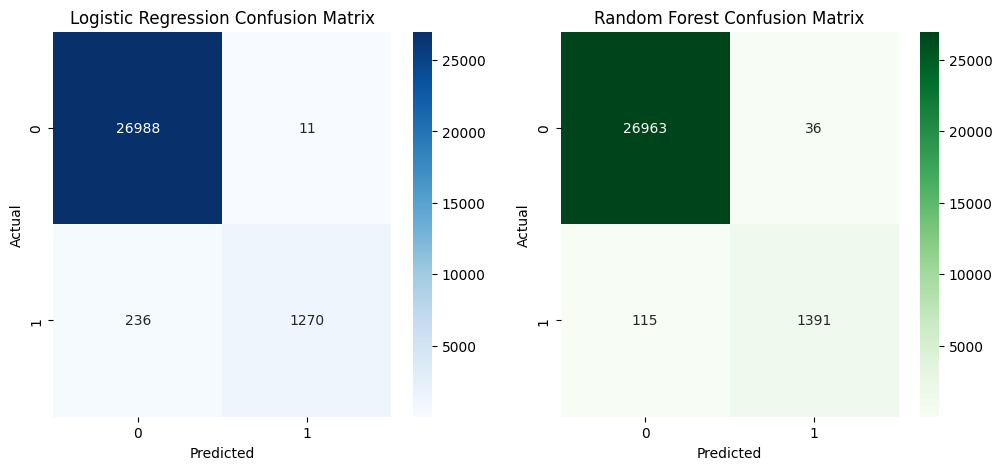

<Figure size 700x500 with 0 Axes>

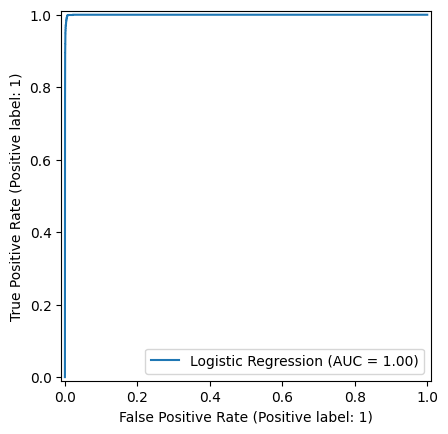

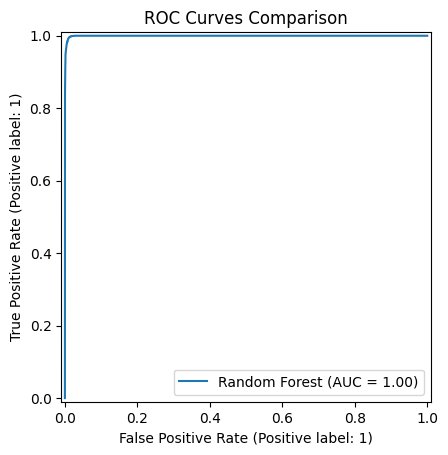

/tmp/ipython-input-2044988691.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_imp, palette="viridis")


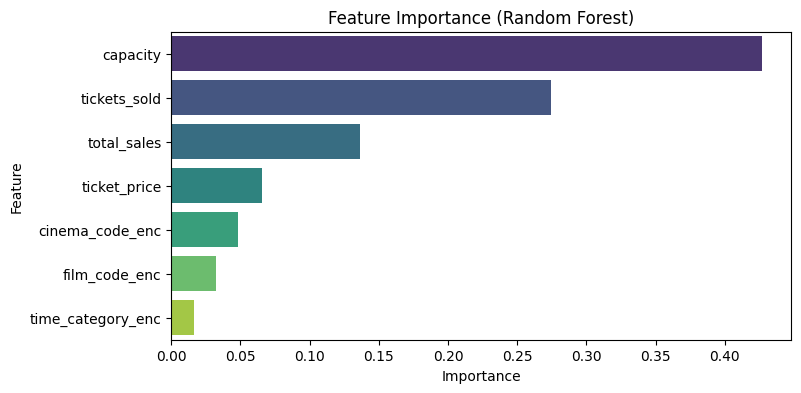

In [11]:
# Predicting Cinema Show Occupancy (High vs Low)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.impute import SimpleImputer

# Set Data set path and load csv
df = pd.read_csv("cinemaTicket.csv")
print("Dataset loaded successfully!")
print(df.head())

# Checking the dataset
print("\n Basic Info")
print(df.info())

print("\n Missing Values")
print(df.isnull().sum())


# Target Variable: High Occupancy (>=70%)
df["High_Occupancy"] = (df["occu_perc"] >= 70).astype(int)

# Convert show_time into time of day
def time_of_day(time_str):
    try:
        hour = int(str(time_str).split(':')[0])
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    except:
        return 'Unknown'

df["time_category"] = df["show_time"].apply(time_of_day)

# Categorical Variables
le = LabelEncoder()
df["film_code_enc"] = le.fit_transform(df["film_code"].astype(str))
df["cinema_code_enc"] = le.fit_transform(df["cinema_code"].astype(str))
df["time_category_enc"] = le.fit_transform(df["time_category"].astype(str))

# Handle Missing Value

# Numeric columns
num_cols = ["ticket_price", "capacity", "total_sales", "tickets_sold"]
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Categorical columns
cat_cols = ["film_code_enc", "cinema_code_enc", "time_category_enc", "cinema_code_enc"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Check if any missing values remain
print("\nMissing values after imputation")
print(df[num_cols + cat_cols].isnull().sum())

# Feature Selection
features = [
    "film_code_enc",
    "cinema_code_enc",
    "ticket_price",
    "capacity",
    "total_sales",
    "tickets_sold",
    "time_category_enc"
]

X = df[features]
y = df["High_Occupancy"]

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

# Model Training

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# --- Random Forest Classifier ---
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation

print("\nLogistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

print("\nRandom Forest Results")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Logistic Regression Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title("Random Forest Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.show()

# ROC Curves
plt.figure(figsize=(7,5))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest")
plt.title("ROC Curves Comparison")
plt.show()

# Feature Importance (Random Forest)
importances = rf.feature_importances_
feature_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x="Importance", y="Feature", data=feature_imp, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.show()